In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, MACCSkeys
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Generate fingerprints

## Get fingerprints

input: SMILES

output: different fingerprints arrays

modification: the types of fingerprints

In [3]:
# Function to get fingerprints for different fingerprints
def get_all_fingerprints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate fingerprints and convert directly to NumPy arrays
    fingerprints = {
        'Morgan (ECFP)': np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048), dtype=int),  # Morgan fingerprint (ECFP)
        'FCFP': np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, useFeatures=True), dtype=int),  # FCFP
        'RDKit': np.array(rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048).GetFingerprint(mol), dtype=int),  # RDKit
        'Atom Pair': np.array(rdFingerprintGenerator.GetAtomPairGenerator(fpSize=2048).GetFingerprint(mol), dtype=int),  # Atom Pair
        'Topological Torsion': np.array(rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=2048).GetFingerprint(mol), dtype=int),  # Topological Torsion
        'MACCS': np.array(MACCSkeys.GenMACCSKeys(mol), dtype=int),  # MACCS is 167 bits long
        'ALL': np.hstack([
            np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048), dtype=int),
            np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, useFeatures=True), dtype=int),
            np.array(rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048).GetFingerprint(mol), dtype=int),
            np.array(rdFingerprintGenerator.GetAtomPairGenerator(fpSize=2048).GetFingerprint(mol), dtype=int),
            np.array(rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=2048).GetFingerprint(mol), dtype=int),
            np.array(MACCSkeys.GenMACCSKeys(mol), dtype=int)
        ])
    }
    
    return fingerprints


## Generate fingerprint Matrix

input: input file containing molecular Names, SMILES, Categories

output: dataframe with specific type of fingerprints, molecular Names, Categories

function: get specific fingerprints using get_all_fingerprints(smiles) and make it able to perform PCA, like adding the name and categories for plotting

modification: Add 'Category' and 'Name' columns can change to add other columns


In [4]:
# Example function to extract one specific fingerprint (e.g., Morgan (ECFP)) from all SMILES in a DataFrame
def extract_specific_fingerprint(chembl_df, fingerprint_func, target_fingerprint, smiles_column='SMILES'):
    """
    Extract a specific fingerprint from the SMILES column in a DataFrame.

    Parameters:
    - chembl_df: DataFrame containing the 'SMILES', 'Name', and 'Category' columns.
    - fingerprint_func: Function that takes a SMILES string and returns a dictionary of fingerprints.
    - target_fingerprint: The name of the fingerprint to extract (e.g., 'Morgan (ECFP)').
    - smiles_column: The column name for SMILES strings in the DataFrame.

    Returns:
    - fingerprint_df: DataFrame containing the specified fingerprint along with 'Name' and 'Category'.
    """
    # Extract the SMILES column
    smiles_list = chembl_df[smiles_column].tolist()

    # Collect the specific fingerprint for all molecules
    fingerprints = [fingerprint_func(smiles)[target_fingerprint] for smiles in smiles_list]

    # Convert the fingerprints to a DataFrame
    fingerprint_df = pd.DataFrame(fingerprints)
    
    # Add 'Category' and 'Name' columns
    fingerprint_df['Category'] = chembl_df['Category'].values
    fingerprint_df['Name'] = chembl_df['Name'].values

    # Display the first few rows of the fingerprint DataFrame
    print(f"\n{target_fingerprint} Fingerprint DataFrame:")
    print(fingerprint_df.head())
    # fingerprint_df.to_csv(f'{target_fingerprint}.csv', index=False)

    return fingerprint_df


# PCA

pca plot with title of the combination of fingerprints
modification: the path to save the plots

In [5]:
def plot_pca(fingerprint_df, n_components=2, combination_name=''):
    fingerprint_df['Category'] = fingerprint_df['Category'].str.strip()  # Removes leading/trailing spaces from the 'Category' column
    fingerprint_matrix = fingerprint_df.drop(columns=['Name', 'Category'])
    
    scaler = StandardScaler()
    fingerprint_matrix_scaled = scaler.fit_transform(fingerprint_matrix)
    
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(fingerprint_matrix_scaled)
    
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n_components)], index=fingerprint_df['Name'])
    pca_df['Category'] = fingerprint_df['Category'].values
    
    explained_variance = pca.explained_variance_ratio_
    
    categories = pca_df['Category'].unique()
    colors = plt.get_cmap('tab10')
    category_color_map = {category: colors(i) for i, category in enumerate(categories)}
    
    num_points = len(pca_df)
    
    plt.figure(figsize=(10, 8))
    for category in categories:
        subset = pca_df[pca_df['Category'] == category]
        plt.scatter(subset['PC1'], subset['PC2'], label=category, color=category_color_map[category], alpha=0.7)
        
        # If the category is 'unknown', annotate the points with molecule names
        if category == 'Unknown':
            for i, name in enumerate(subset.index):
                plt.annotate(name, (subset['PC1'].iloc[i], subset['PC2'].iloc[i]),
                             fontsize=8, alpha=0.75)

    plt.title(f'PCA of Fingerprints: {combination_name} (N={num_points})')
    plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% Variance)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% Variance)')
    plt.grid(True)
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot to a file
    plt.savefig(f'{"/Users/xiaomuou620/Library/CloudStorage/OneDrive-UniversityofCopenhagen/courses/Project1/Fingerprint/pca_plots_N=40"}/PCA_{combination_name}.png', bbox_inches='tight')
    
    return pca_df, explained_variance


# Run

## Example

In [7]:
chembl_example = pd.read_csv(
    "../../data/ExperimentData/43_Psychedelic_drug_SMILES_Category.csv"
    # sep=",", header=0
)
# print(chembl_example.head())

### For all

In [8]:
fingerprint_df = extract_specific_fingerprint(chembl_example, get_all_fingerprints, 'RDKit')



RDKit Fingerprint DataFrame:
   0  1  2  3  4  5  6  7  8  9  ...  2040  2041  2042  2043  2044  2045  \
0  1  0  0  0  0  1  1  0  1  1  ...     0     1     0     0     0     0   
1  1  0  0  1  0  1  1  1  1  1  ...     0     1     0     0     0     0   
2  1  0  0  0  0  1  1  1  1  1  ...     0     1     0     0     0     0   
3  1  0  0  0  0  1  1  1  1  1  ...     0     1     0     0     0     0   
4  1  0  0  0  0  1  1  1  1  1  ...     0     1     0     0     0     0   

   2046  2047    Category        Name  
0     0     1  Tryptamine        5-HT  
1     0     1  Tryptamine  4-AcO-MALT  
2     0     1  Tryptamine   5-MeO-DMT  
3     0     1  Tryptamine  5-MeO-DALT  
4     0     1  Tryptamine  5-MeO-DiPT  

[5 rows x 2050 columns]


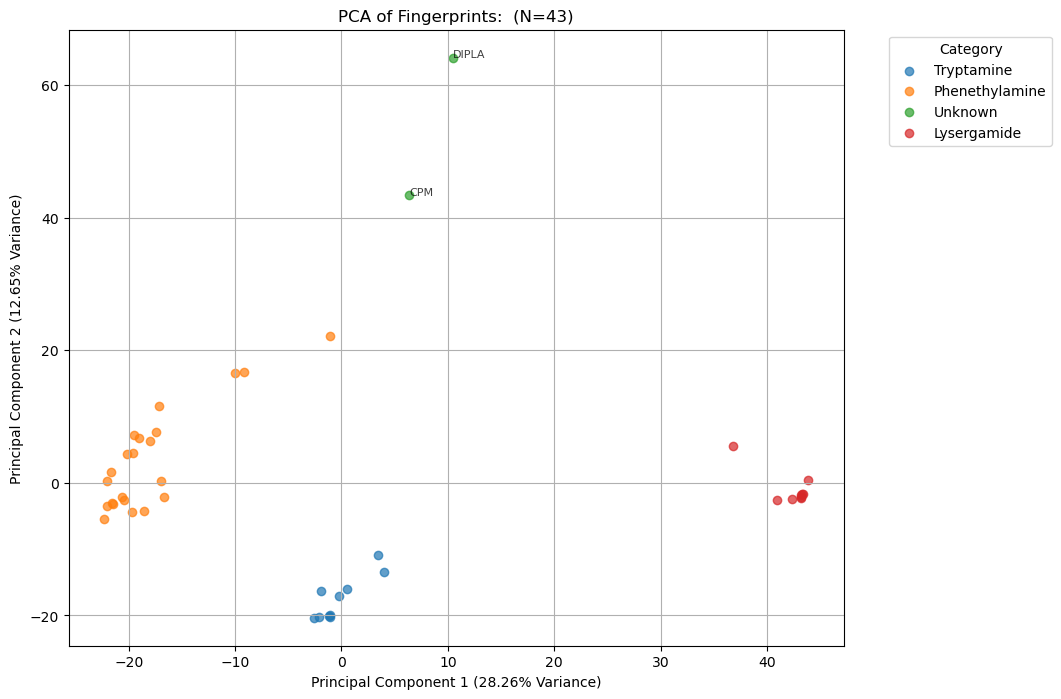

In [9]:
fingerprint_df, explained_variance = plot_pca(fingerprint_df, n_components=2)

### For different combinations

In [8]:
import itertools

# List of all fingerprints
fingerprint_all = ['Morgan (ECFP)', 'FCFP', 'RDKit', 'Atom Pair', 'Topological Torsion', 'MACCS']

# Generate all possible subsets as a list of lists
# all_subsets = [list(subset) for r in range(len(fingerprint_all) + 1) for subset in itertools.combinations(fingerprint_all, r)]

# # Output all subsets
# for subset in all_subsets:
#     print(subset)

# print(all_subsets)



Processing fingerprint combination: MACCS

MACCS Fingerprint DataFrame:
   0  1  2  3  4  5  6  7  8  9  ...  159  160  161  162  163  164  165  166  \
0  0  0  0  0  0  0  0  0  0  0  ...    1    0    1    1    1    1    1    0   
1  0  0  0  0  0  0  0  0  0  0  ...    1    1    1    1    1    1    1    0   
2  0  0  0  0  0  0  0  0  0  0  ...    0    1    1    1    1    1    1    0   
3  0  0  0  0  0  0  0  0  0  0  ...    0    1    1    1    1    1    1    0   
4  0  0  0  0  0  0  0  0  0  0  ...    0    1    1    1    1    1    1    0   

     Category        Name  
0  Tryptamine        5-HT  
1  Tryptamine  4-AcO-MALT  
2  Tryptamine   5-MeO-DMT  
3  Tryptamine  5-MeO-DALT  
4  Tryptamine  5-MeO-DiPT  

[5 rows x 169 columns]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Inte

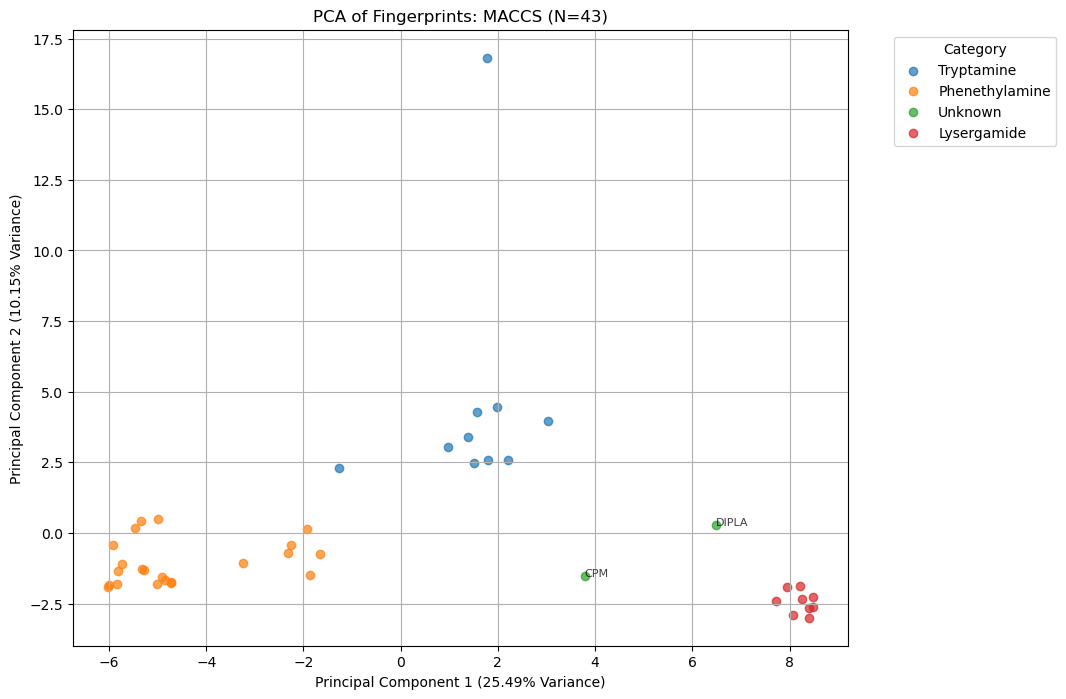

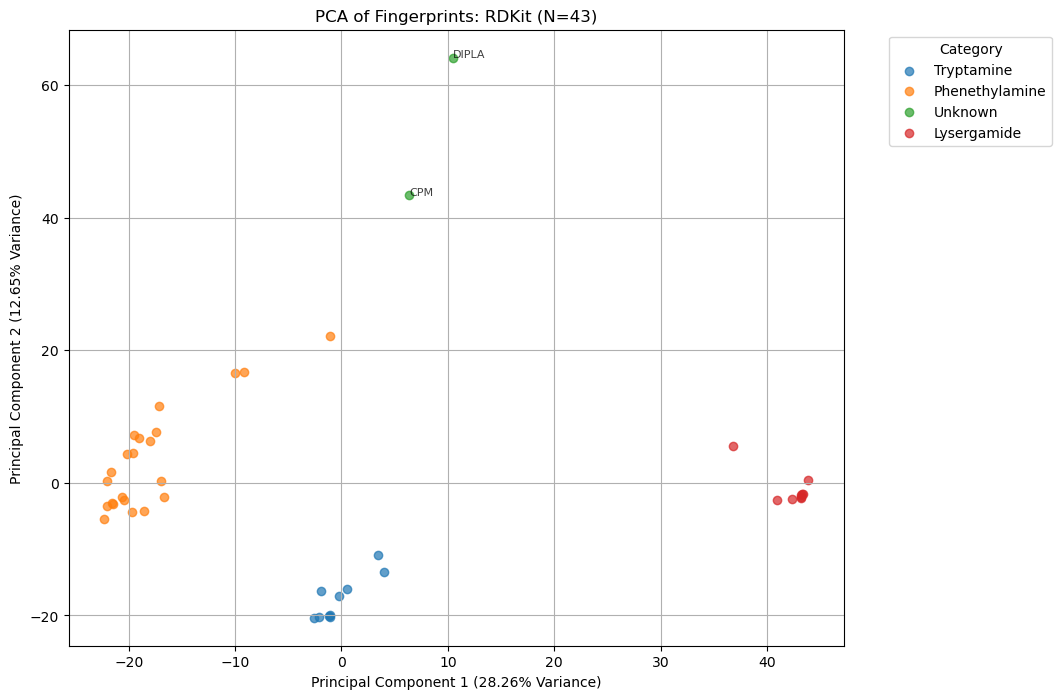

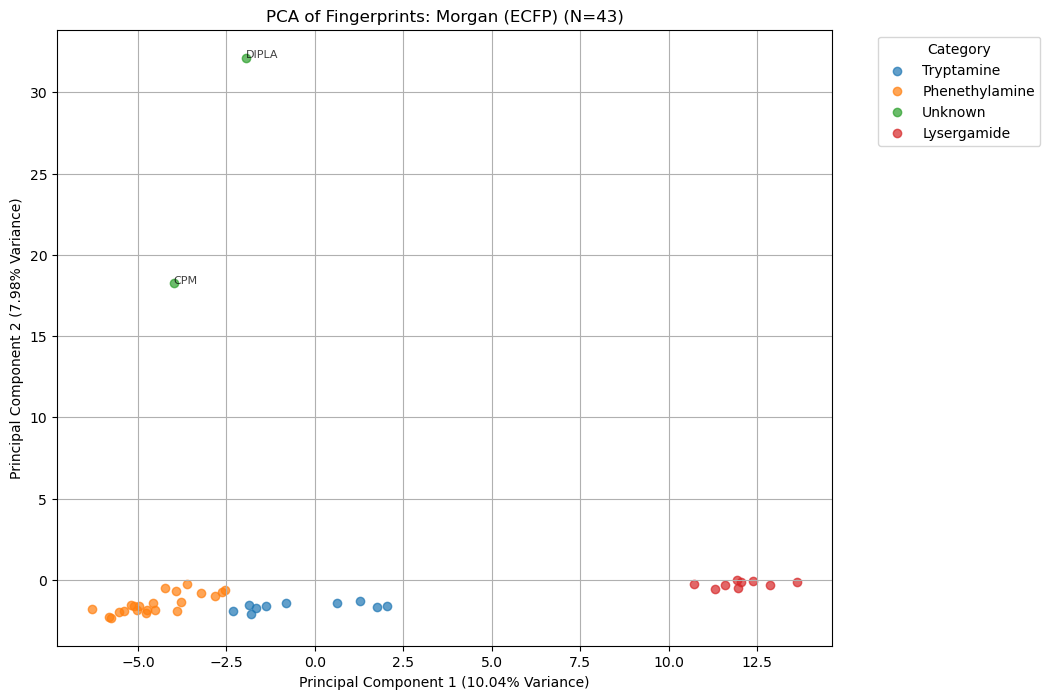

In [10]:
all_subsets = [[],
    # ['Morgan (ECFP)', 'MACCS'],
    ['MACCS'],
    ['RDKit'],
    ['Morgan (ECFP)'],
    
    # ['Atom Pair', 'Topological Torsion']
]
# fingerprint_all = ['Morgan (ECFP)', 'FCFP', 'RDKit', 'Atom Pair', 'Topological Torsion', 'MACCS']
explained_variance_dict = {}

for combinations in all_subsets[1:]:
    combination_name = ' + '.join(combinations)
    print(f"\nProcessing fingerprint combination: {combination_name}")
    
    combined_fingerprints = []
    for combination in combinations:
        fingerprint_df = extract_specific_fingerprint(chembl_example, get_all_fingerprints, combination)
        combined_fingerprints.append(fingerprint_df.drop(columns=['Name', 'Category']))
    
    # Combine fingerprints horizontally
    combined_df = pd.concat(combined_fingerprints, axis=1)
    combined_df['Name'] = chembl_example['Name']
    combined_df['Category'] = chembl_example['Category']
    
    # Perform PCA on the combined fingerprints
    fingerprint_df, explained_variance = plot_pca(combined_df, n_components=2, combination_name=combination_name)
    explained_variance_dict[combination_name] = explained_variance

#### Explained variance

In [10]:
# get explained variance for each combination
explained_variance_df = pd.DataFrame(explained_variance_dict).T

# Sum the explained variance for the first two principal components
explained_variance_df['sum_variance_01'] = explained_variance_df[0] + explained_variance_df[1]

# Sort the DataFrame by the sum of explained variance
sorted_df = explained_variance_df.sort_values(by='sum_variance_01', ascending=False)

# Display the sorted DataFrame
print(sorted_df)

sorted_df.to_csv('PCA_variance.csv')


                      0         1  sum_variance_01
RDKit          0.282575  0.126497         0.409072
MACCS + RDKit  0.280226  0.123365         0.403592
Morgan (ECFP)  0.100359  0.079790         0.180149


## 250

In [11]:
chembl_250 = pd.read_csv(
    "psychedelics_all_fingerprints.csv"
    # sep=",", header=0
)
print(chembl_250.head())

                     Name    Category     CID  \
0               Quipazine  Piperazine    5011   
1                   MK212  Piperazine  107992   
2  N,N-Dimethyltryptamine  Tryptamine    6089   
3                Psilocin  Tryptamine    4980   
4              Psilocybin  Tryptamine   10624   

                                            Synonyms  \
0  ['quipazine', '2-Piperazin-1-yl-quinoline', '4...   
1  ['MK-212', '64022-27-1', '2-Chloro-6-(1-pipera...   
2  ['N,N-DIMETHYLTRYPTAMINE', 'DIMETHYLTRYPTAMINE...   
3  ['PSILOCIN', 'Psilocine', '4-Hydroxy-N,N-dimet...   
4  ['Psilocybin', 'Psilocybine', 'Indocybin', 'Ps...   

                       Canonical SMILES                       Isomeric SMILES  \
0         C1CN(CCN1)C2=NC3=CC=CC=C3C=C2         C1CN(CCN1)C2=NC3=CC=CC=C3C=C2   
1             C1CN(CCN1)C2=CN=CC(=N2)Cl             C1CN(CCN1)C2=CN=CC(=N2)Cl   
2              CN(C)CCC1=CNC2=CC=CC=C21              CN(C)CCC1=CNC2=CC=CC=C21   
3           CN(C)CCC1=CNC2=C1C(=CC=C2)O     

In [12]:
fingerprint_df_250 = extract_specific_fingerprint(chembl_250, get_all_fingerprints, smiles_column='Canonical SMILES', target_fingerprint='RDKit')


RDKit Fingerprint DataFrame:
   0  1  2  3  4  5  6  7  8  9  ...  2040  2041  2042  2043  2044  2045  \
0  1  0  0  0  0  1  1  0  0  0  ...     0     1     1     0     0     0   
1  0  0  0  0  0  1  1  0  0  0  ...     1     0     0     0     1     0   
2  1  0  0  0  0  1  0  1  1  1  ...     0     1     0     0     0     0   
3  1  0  0  0  0  1  1  1  1  1  ...     0     1     0     0     0     0   
4  1  0  0  0  0  1  1  1  1  1  ...     1     1     0     0     0     1   

   2046  2047    Category                    Name  
0     0     1  Piperazine               Quipazine  
1     1     1  Piperazine                   MK212  
2     0     1  Tryptamine  N,N-Dimethyltryptamine  
3     0     1  Tryptamine                Psilocin  
4     1     1  Tryptamine              Psilocybin  

[5 rows x 2050 columns]


In [13]:
print(fingerprint_df_250.head())

   0  1  2  3  4  5  6  7  8  9  ...  2040  2041  2042  2043  2044  2045  \
0  1  0  0  0  0  1  1  0  0  0  ...     0     1     1     0     0     0   
1  0  0  0  0  0  1  1  0  0  0  ...     1     0     0     0     1     0   
2  1  0  0  0  0  1  0  1  1  1  ...     0     1     0     0     0     0   
3  1  0  0  0  0  1  1  1  1  1  ...     0     1     0     0     0     0   
4  1  0  0  0  0  1  1  1  1  1  ...     1     1     0     0     0     1   

   2046  2047    Category                    Name  
0     0     1  Piperazine               Quipazine  
1     1     1  Piperazine                   MK212  
2     0     1  Tryptamine  N,N-Dimethyltryptamine  
3     0     1  Tryptamine                Psilocin  
4     1     1  Tryptamine              Psilocybin  

[5 rows x 2050 columns]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


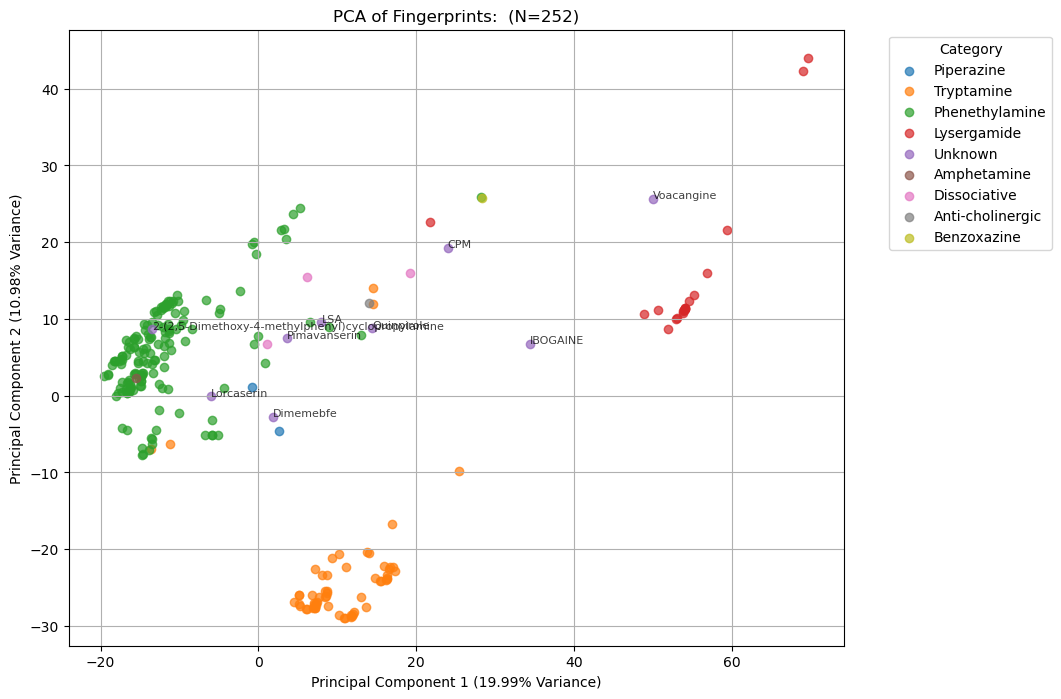

In [14]:
fingerprint_df_250, explained_variance_250 = plot_pca(fingerprint_df_250, n_components=2)
